In [1]:
from tqdm.notebook import tqdm
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

from datasets import load_dataset

from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertModel, BertForSequenceClassification
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

from IPython.display import clear_output
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display

from pprint import pprint

sns.set(font_scale=1.2)
sns.set_style(style='whitegrid')
device_num = 0

from pathlib import Path
import shutil
import os
import logging
import sys
sys.path.append('..')

from textblob import TextBlob
from pprint import pprint
from sklearn.metrics import classification_report

import os
import argparse
import datetime

from pathlib import Path
from pytorch_pretrained_bert.modeling import BertForSequenceClassification

from transformers import BertTokenizer, BertConfig, DataCollatorWithPadding
from transformers import AdamW, BertModel, BertForSequenceClassification
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

%load_ext autoreload
%autoreload 2
import scipy.stats as sps
project_dir = Path.cwd().parent

from finBERT.finbert.utils import *
from nltk.tokenize import sent_tokenize

import itertools

import re
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

**Предсказание**

Функция `predict` и часть функций внутри неё взяты из [гитхаба](https://github.com/ProsusAI/finBERT/tree/master) дообученной на финансовых новостях модели `BERT`'a

In [2]:
def predict(text, model, batch_size=1, write_to_csv=False, path=None, tokenazer_size=64):
    """
    Predict sentiments of sentences in a given text. The function first tokenizes sentences, make predictions and write
    results.

    Parameters
    ----------
    text: string
        text to be analyzed
    model: BertForSequenceClassification
        path to the classifier model
    write_to_csv (optional): bool
    path (optional): string
        path to write the string
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    sentences = sent_tokenize(text)

    label_list = ['positive', 'negative', 'neutral']
    label_dict = {0: 'positive', 1: 'negative', 2: 'neutral'}
    result = pd.DataFrame(columns=['sentence','logit','prediction','sentiment_score'])
    active_len = []
    
    for batch in chunks(sentences, batch_size):

        examples = [InputExample(str(i), sentence) for i, sentence in enumerate(batch)]

        features = convert_examples_to_features(examples, label_list, tokenazer_size, tokenizer)
        
        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long).to(device)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long).to(device)
        all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long).to(device)
        
        active_len = len(all_input_ids[all_input_ids != 0])
        
        with torch.no_grad():
            model.zero_grad()

            logits = model(all_input_ids, all_attention_mask, all_token_type_ids, output_attentions=True)
            logits, all_hidden_states, all_attentions =  logits['logits'], logits['hidden_states'],  logits['attentions']
            logits = softmax(np.array(logits))
            
            sentiment_score = pd.Series(logits[:,0] - logits[:,1])
            predictions = np.squeeze(np.argmax(logits, axis=1))

            batch_result = {'sentence': batch,
                            'logit': list(logits),
                            'prediction': predictions,
                            'sentiment_score':sentiment_score}
            
            batch_result = pd.DataFrame(batch_result)
            result = pd.concat([result,batch_result])

    result['prediction'] = result.prediction.apply(lambda x: label_dict[x])
    if write_to_csv:
        result.to_csv(path,sep=',', index=False)
    
    # Переводим из tuple в np.array
    _attentions = [att.detach().numpy() for att in all_attentions]
    all_attentions = np.asarray(_attentions)[:, 0]
    
    return result, all_hidden_states, all_attentions, active_len

**Сжатие токенов в слова**  

При токенизации может быть так, что длинное слово представляется в виде не одного, а нескольких токенов. Например:

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer.tokenize("Amsteradam")

['am', '##ster', '##ada', '##m']

При этом, визуализируя тепловую карту внимания, нам бы хотелось видеть вдоль оси целые слова, а не их куски. Следующая функция создаёт кортеж слов, которые будут задавать ось Ox на карте, при этом при желании сжимает токены разбитого слова в один. При сжати также возвращаются позиции, на которых начинаются разбитые на несколько токенов слова, и количество токенов, на которое распалось слово.

*Замечание:* применение функции `split()` в данном случае трудно представляется, т.к. токенизатор кроме слов и частей слов ещё отдельно токенизирует разные спец. символы. Обработать все возможные спец. символы в данном случае кажется трудной задачей.

In [22]:
def tokens_to_word_for_xticklb(text, tokenizer):
    xticklb = []
    ids = []

    tokens = ['[CLS]'] + tokenizer.tokenize(text) + ["[SEP]"]
    for i in range(len(tokens)):
        if tokens[i][:2] == '##':
            xticklb[-1] += tokens[i][2:]
            ids[-1][1] += 1
        else:
            xticklb.append(tokens[i])
            ids.append([i, 1])

    return {'xticklb': xticklb,
            'ids': ids}

Далее, если был выбран вариант сжать токены в слова, нужно также сжать матрицу внимания. В данном случае выбран вариант суммировать внимание нескольких токенов, относящихся к одному слову.

In [24]:
def compress_attention(att, ids):
    att = [att.T[ids[i][0]:ids[i][0] + ids[i][1]].sum(axis=0) for i in range(len(ids))]
        
    return np.array(att).T[:, :len(ids)]

**Тепловая карта внимания**  

Научимся превращать матрицу весов внимания размерности  `layers x heads x seq_len x seq_len` в двумерную матрицу `layers x seq_len`.  

1. Усредним внимание по головам (в следующей функции). Предполагая, что из-за **Dropout'а** головы на одних слоях обучаются обращать внимание примерно на одни и те синтаксические зависимости.
2. Обрежем оси тепловой карты. Развернём массив по оси слоёв, чтобы на тепловой карте номер слоя увеличивался снизу вверх. Сделаем срез массива по токенy `CLS`, т.к. именно он используется моделью для предсказания (в целом, можно указать номер любого токена и увидеть его тепловую карту).
3. Сожмём тепловую карту, если нужно показать карту по словам, а не по токенам.
4. Возвращать будем массив самой тепловой карты и её оси.

In [71]:
def compute_axes(
    text, tokenizer, attention,
    left, right, first_layer, last_layer
):
    if right == None:
        right = attention.shape[1] + 1
    if last_layer == None:
        last_layer = attention.shape[0]

    result = tokens_to_word_for_xticklb(text, tokenizer)
    xticklb = tuple(result['xticklb'][left:right])
    yticklb = tuple([str(i) if i % 2 ==0 else '' for i in \
                     np.arange(attention.shape[0], 0 , -1)][attention.shape[0] - \
                                                            last_layer:attention.shape[0] - first_layer + 1])

    return {'xticklb' : xticklb,
            'yticklb' : yticklb,
            'ids' : result['ids']}

In [54]:
def attention_heatmap(
    text, tokenizer, attention, active_len,
    left=0, right=None, first_layer=1, last_layer=None,
    xticklb=None, yticklb=None, ids=None,
    vmax=None, model_name='default',
):

    if right == None:
        right = active_len + 1
    if last_layer == None:
        last_layer = attention.shape[0]
    
    # Данные для Ох
    if xticklb == None or yticklb == None or ids == None:
        result = compute_axes(
            text, tokenizer, attention,
            left, right, first_layer, last_layer
        )
        xticklb = result['xticklb']
        yticklb = result['yticklb']
        ids = result['ids']

    # Разворачиваем и обрезаем массив, сжимаем
    cls_att = np.flip((attention[first_layer - 1:last_layer])[:, 0, 0:active_len], axis=0)
    cls_att = compress_attention(cls_att, ids)[:, left:right]

    # Строит тепловую карту
    plt.figure(figsize=(20, 3))  
    sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, vmax=vmax, cmap="YlOrRd")
    plt.title(f'Тепловая карта токен-слой для модели {model_name}')
        
    return cls_att, xticklb, yticklb

Преобразуем входной текст в тепловую карту внимания.

In [62]:
def sequence_to_attention_map(
    text, tokenizer, outputs,
    left=0, right=None, first_layer=1, last_layer=None,
    xticklb=None, yticklb=None, ids=None,
    vmax=None, model_name='default',
):

    result, all_hidden_states, all_attentions, active_len = outputs

    # Усреднение по головам
    attention = all_attentions.sum(axis=1) / all_attentions.shape[1]
    
    # Строит тепловую карту выбранной части предложения
    heat_map, Ox, Oy = attention_heatmap(
        text, tokenizer, attention, active_len,
        left=left, right=right, first_layer=first_layer, last_layer=last_layer,
        vmax=vmax, model_name=model_name,
    )

    return heat_map, Ox, Oy

Выберем базовую модель `BERT` для классификации и предложение из финансовых новостей.

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      cache_dir=None,
                                                      output_attentions=True,
                                                      output_hidden_states=True)

text = "Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as" \
       " Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands," \
       " September 11, 2019."
text = 'Shares in the spin-off of South African e-commerce group Naspers surged more than 25%' \
        'in the first minutes of their market debut in Amsterdam on Wednesday.'

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Посмотрим на тепловую карту слоёв внимания для фрагмента предложения

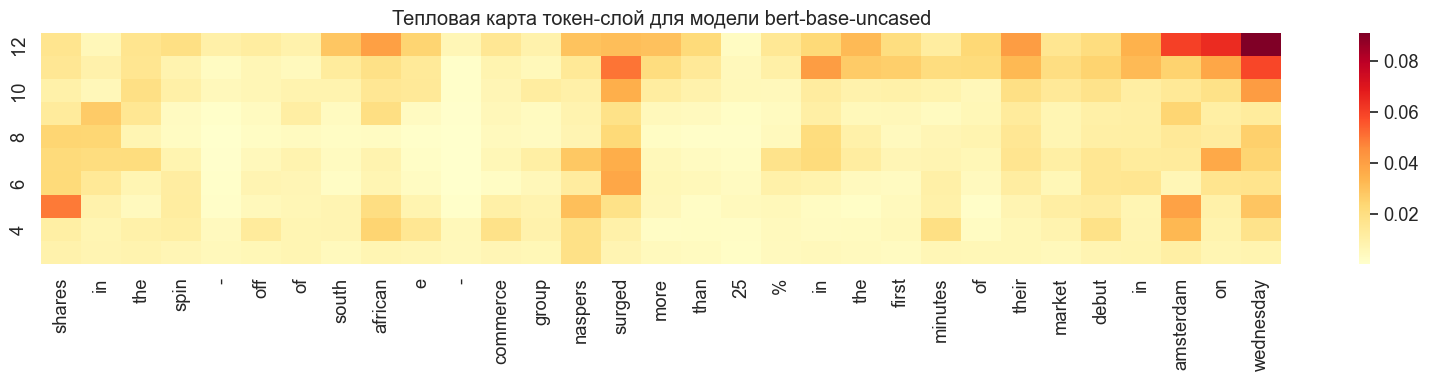

In [42]:
outputs = predict(text, model, write_to_csv=False)

heat_map, Ox, Oy = sequence_to_attention_map(
    text, tokenizer, outputs,
    1, -2, 3, 12,
    vmax=None, model_name='bert-base-uncased'
)

**Визуальное сравнение двух моделей**  

В каждой модели разные головы могут с разной силой реагировать на токены, поэтому для большей наглядности обе тепловые карты должны отображать один масштаб. 

In [58]:
def max_prob_between_2_models(
    text, tokenizer, outputs_1, outputs_2, 
    left, right, first, last, ids,
):
    
    attention = outputs_1[2].sum(axis=1) / outputs_1[2].shape[1]
    cls_att = np.flip((attention[first - 1:last])[:, 0, 0:outputs_1[3]], axis=0)
    attention_1 = compress_attention(cls_att, ids)[:, left:right]
    
    attention = outputs_2[2].sum(axis=1) / outputs_2[2].shape[1]
    cls_att = np.flip((attention[first - 1:last])[:, 0, 0:outputs_2[3]], axis=0)
    attention_2 = compress_attention(cls_att, ids)[:, left:right]
    
    return np.max([attention_1, attention_2])

Осталось просто сравнить две модели. Для большей наглядности посмотрим на тепловую карту разницы дообученной и обычной модели.

In [60]:
def stat_versus_models_token_layer(
    text, tokenizer, outputs_1, outputs_2, 
    left=0, right=None, first=1, last=None,
    model_1_name='model 1', model_2_name='model 2'
):
    result = compute_axes(
        text, tokenizer, outputs_1[2],
        left, right, first, last,
    )
    vmax = max_prob_between_2_models(
        text, tokenizer, outputs_1, outputs_2, 
        left, right, first, last, result['ids'],
    )
    heat_map_1, Ox_1, Oy_1 = sequence_to_attention_map(
        text, tokenizer, outputs_1,
        left, right, first, last,
        xticklb=result['xticklb'], yticklb=result['yticklb'], ids=result['ids'],
        model_name=model_1_name, vmax=vmax,
    )
    heat_map_2, Ox_2, Oy_2 = sequence_to_attention_map(
        text, tokenizer, outputs_2,
        left, right, first, last,
        xticklb=result['xticklb'], yticklb=result['yticklb'], ids=result['ids'],
        model_name=model_2_name, vmax=vmax,
    )

    first = heat_map_1[0].ravel()
    second = heat_map_2[0].ravel()
    plt.figure(figsize=(20, 3))
        
    abs_diff = np.max(heat_map_2 - heat_map_1)
        
    sns.heatmap(
        heat_map_2 - heat_map_1, 
         xticklabels=Ox_1, 
         yticklabels=Oy_1, 
         vmin=-abs_diff, vmax=abs_diff,
         cmap="coolwarm"
    )
    plt.title(f'Разница тепловых карт вида модель {model_2_name} - {model_1_name}')

Зададим токенайзер и две модели

In [44]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    cache_dir=None,
    output_attentions=True,
    output_hidden_states=True,
)

model_finbert = BertForSequenceClassification.from_pretrained(
    "finBERT/models/classifier_model/finbert-sentiment/",
    num_labels=3,
    cache_dir=None,
    output_attentions=True,
    output_hidden_states=True,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
text = 'Shares in the spin-off of South African e-commerce group Naspers surged more than 25%' \
        'in the first minutes of their market debut in Amsterdam on Wednesday.'
text = "Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as" \
        " Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019."

outputs_1 = predict(text, model_bert, write_to_csv=False)
outputs_2 = predict(text, model_finbert, write_to_csv=False)

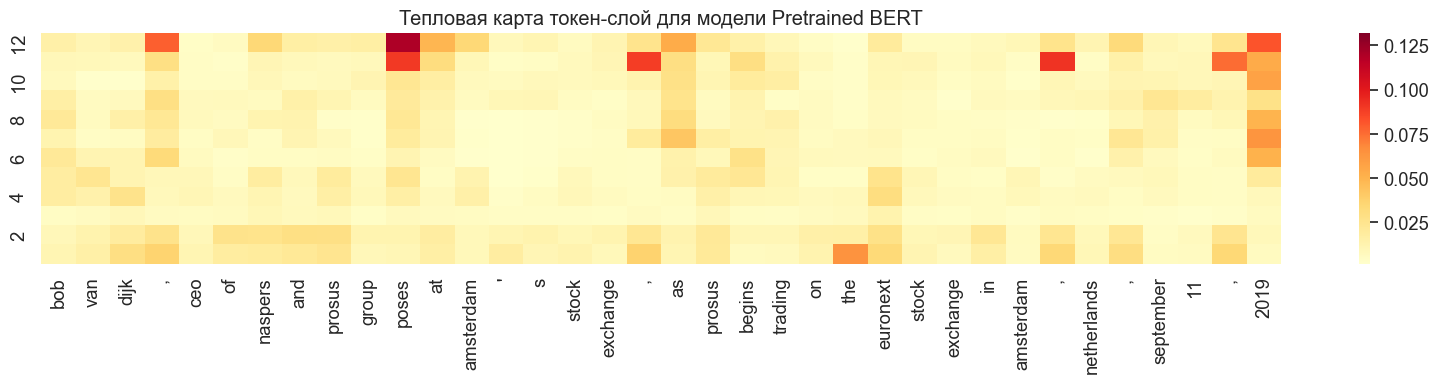

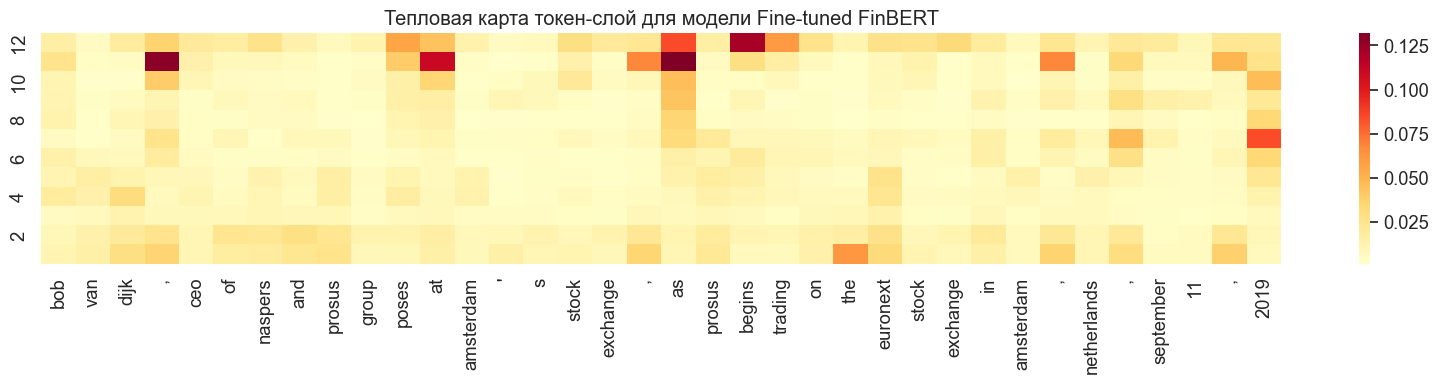

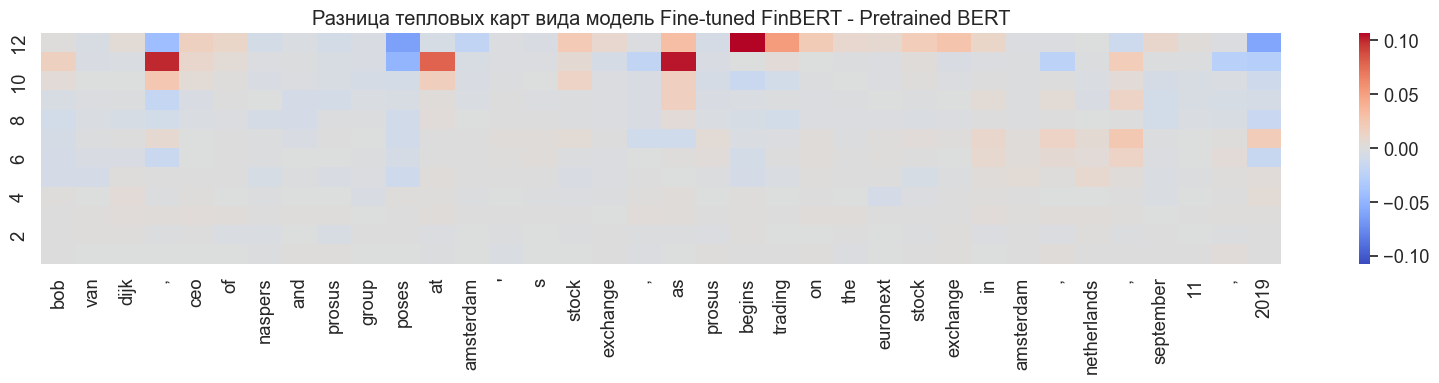

In [73]:
ttest_result = stat_versus_models_token_layer(
    text, tokenizer, outputs_1, outputs_2, 
    1, -2, #3, 10,
    model_1_name='Pretrained BERT', model_2_name='Fine-tuned FinBERT',
)

In [22]:
# print(f'T-test: {ttest_result}')

1. головы по квадратикам seq2seq
2. token2words на осях
3. визуализация конкретных голов

**Конкретные головы**  

Для начала переделаем немного функцию, сжимающую слова, если мы хотим увидеть карту по словам, а не по токенам. Для этого аналогично сожмём столбцы токенов одного слова суммой, а вот по строчкам будем усреднять.

In [23]:
def compress_head_att_for_words(att, ids):
    att = np.array([att.T[ids[i][0]:ids[i][0] + ids[i][1]].sum(axis=0) \
                    for i in range(len(ids))]).T[:, :len(ids)]
    att = np.array([att[ids[i][0]:ids[i][0] + ids[i][1]].mean(axis=0) \
                    for i in range(len(ids))])[:len(ids), :]
    return att

Теперь изменим функцию построения тепловой карты, чтобы она отрисовывала конкретную голову на конкретном слое

In [58]:
def attention_heatmap_for_head(text, tokenizer, head_att, active_len,
                               left=0, right=None, layer=1, head=1,
                               unite_words=False,
                               build_plot=True, vmax=None, ax=None, model_name='default'):

    if right == None:
        right = active_len + 1
        
    if right <= left:
        left = 1
        right = active_len
    
    # Данные для Ох и Оу
    result = tokens_to_word_for_xticklb(text, tokenizer, unite_words)
    
    # Обрезаем оси
    xticklb = yticklb = tuple(result['xticklb'][left:right])
    
    # Обрезаем массив attention'ов по числу активных токенов
    cls_att = head_att[0:active_len, 0:active_len]

    # Объединяем массив в карту для слов, а не токенов
    if unite_words:
        ids = result['ids']
        cls_att = compress_head_att_for_words(cls_att, ids)  # !!!!!!!
    cls_att = cls_att[left:right, left:right]

    # Строит тепловую карту
    if build_plot:
        size = 7
        sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb,
                              vmax=vmax, cmap="YlOrRd", ax=ax)
        # Устанавливаем размер шрифта для подписей осей
        size = 15
        if ax != None:        
            ax.tick_params(axis='x', labelsize=size)
            ax.tick_params(axis='y', labelsize=size)
            ax.set_title(f'Слой - {layer}, Голова - {head}')
        else:
            plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=size)
            plt.gca().set_yticklabels(plt.gca().get_yticklabels(), fontsize=size)
            plt.title(f'Слой - {layer}, Голова - {head}')
    return cls_att, xticklb, yticklb

Наконец, отобразим как конкретный токен влияет на все остальные на выбранной голове и выбранном слое. По оси Оу - слова, для которых генерируется следущий токен, т.е. в выбранной строке мы видим разложение attention'a этого слова по всем остальным.

In [25]:
def seq2seq_head_layer_att_map(text, tokenizer, outputs,
                               left=0, right=None, layer=1, head=1,
                               unite_words=False, build_plot=True, ax=None, model_name='default',
                               vmax=None):

    result, all_hidden_states, all_attentions, active_len = outputs

    # Выбираем слой и голову и слой
    if head == 'mean':
        att_heat_map = all_attentions.sum(axis=1) / all_attentions.shape[1]
        att_heat_map = att_heat_map[int(layer) - 1]
    else:
        att_heat_map = all_attentions[int(layer) - 1, int(head) - 1]
    
    # Строит тепловую карту выбранной части предложения
    heat_map, Ox, Oy = attention_heatmap_for_head(
        text, tokenizer, att_heat_map,
        left=left, right=right, layer=layer, head=head,
        active_len=active_len,
        unite_words=unite_words,
        build_plot=build_plot,
        vmax=vmax,
        model_name=model_name,
        ax=ax,
    )

    return heat_map, Ox, Oy

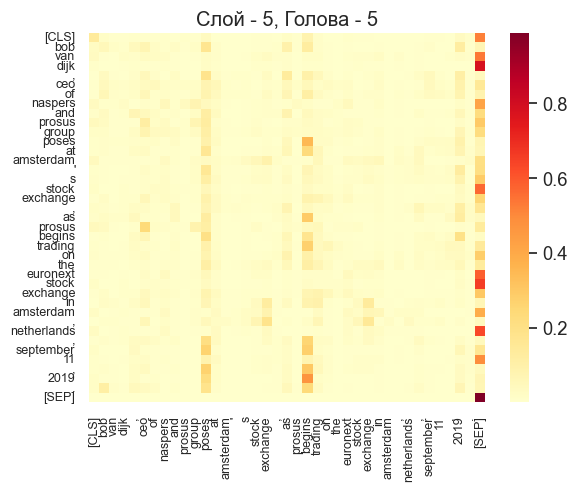

In [30]:
a = seq2seq_head_layer_att_map(text, tokenizer, outputs,
                               layer=5, head=5,
                               unite_words=True)

Наконец, сделаем виджет, где сможем менять голову и слой  

Зададим регулируемые параметры

In [45]:
unite_words = True
difference = True

# Задаем дискретные значения для ползунков
left_values = right_values = word_active_len = 0

if unite_words:
    result = tokens_to_word_for_xticklb(text, tokenizer, unite_words)
    word_active_len = len(result['ids'])
else:
    word_active_len = outputs[-1]

left_values = np.linspace(0, word_active_len - 1, word_active_len).astype(int)
right_values = np.linspace(1, word_active_len, word_active_len).astype(int)
    
layer_values = np.linspace(1, 12, 12).astype(int)
head_values = np.linspace(1, 12, 12).astype(int)

Функция для обновления графика при изменении значений переменных

In [38]:
def update_plot(left, right, layer, head,
                #unite_words=False, build_plot=True, model_name='default',
                #vmax=None
               ):
    a = seq2seq_head_layer_att_map(
        text, tokenizer, outputs,
        left=left, right=right, layer=layer, head=head,
        unite_words=True
    )

In [39]:
# Создаем ползунки с дискретными значениями
left_slider = widgets.SelectionSlider(options=left_values, value=0, description='Left border', continuous_update=False)
right_slider = widgets.SelectionSlider(options=right_values, value=word_active_len, description='Right border', continuous_update=False)

layer_slider = widgets.SelectionSlider(options=layer_values, value=1, description='Layer', continuous_update=False)
head_slider = widgets.SelectionSlider(options=head_values, value=1, description='Head', continuous_update=False)


# Создаем виджет для обновления графика
widgets.interactive(update_plot,
                    left=left_slider,
                    right=right_slider,
                    layer=layer_slider,
                    head=head_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='Left border', options=(0, 1, 2, 3,…

Теперь попробуем сравнить две модели

In [40]:
def max_prob_between_2_models_h_l(text, tokenizer, outputs_1, outputs_2, 
                                  left, right, layer, head,
                                  unite_words):
    att_heat_map = 0
    # Выбираем слой и голову и слой
    if head == 'mean':
        att_heat_map = outputs_1[2].sum(axis=1) / outputs_1[2].shape[1]
        att_heat_map = outputs_1[2][int(layer) - 1]
    else:
        att_heat_map = outputs_1[2][int(layer) - 1, int(head) - 1]
        
    a1 = attention_heatmap_for_head(text, tokenizer, att_heat_map, outputs_1[3],
                           left, right, layer, head,
                           unite_words=unite_words, build_plot=False)
    
    # Выбираем слой и голову и слой
    if head == 'mean':
        att_heat_map = outputs_2[2].sum(axis=1) / outputs_2[2].shape[1]
        att_heat_map = outputs_2[2][int(layer) - 1]
    else:
        att_heat_map = outputs_2[2][int(layer) - 1, int(head) - 1]
    
    a2 = attention_heatmap_for_head(text, tokenizer,  att_heat_map, outputs_2[3],
                           left, right, layer, head,
                           unite_words=unite_words, build_plot=False)
    
    return np.max([a1[0], a2[0]])

In [61]:
def update_plot_2(left, right, layer, head,
                #unite_words=False, build_plot=True, model_name='default',
                #vmax=None
               ):
    vmax = max_prob_between_2_models_h_l(text, tokenizer, outputs_1, outputs_2, 
                                     left, right, layer, head, unite_words)
    
    num_grafs = 2 + int(difference)
    fig, axs = plt.subplots(1, num_grafs, figsize=(30, 8))
    
    heat_map_1, Ox_1, Oy_1 = seq2seq_head_layer_att_map(
        text, tokenizer, outputs_1,
        left=left, right=right, layer=layer, head=head,
        unite_words=True, vmax=vmax, ax=axs[0],
    )

    heat_map_2, Ox_2, Oy_2 = seq2seq_head_layer_att_map(
        text, tokenizer, outputs_2,
        left=left, right=right, layer=layer, head=head,
        unite_words=True, vmax=vmax, ax=axs[1],
    )
    
    if difference:
        first = heat_map_1[0].ravel()
        second = heat_map_2[0].ravel()
        
        abs_diff = np.max(heat_map_2 - heat_map_1)
        
        sns.heatmap(heat_map_2 - heat_map_1, 
                xticklabels=Ox_1, 
                yticklabels=Oy_1, 
                vmin=-abs_diff, vmax=abs_diff,
                cmap="coolwarm",
                ax=axs[2])
        plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=15)
        plt.gca().set_yticklabels(plt.gca().get_yticklabels(), fontsize=15)
        plt.title(f'Слой - {layer}, Голова - {head}, разница двух моделей')

In [62]:
widgets.interactive(update_plot_2,
                    left=left_slider,
                    right=right_slider,
                    layer=layer_slider,
                    head=head_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='Left border', index=1, options=(0,…